### Helper Functions to:
- Recenter the values of Days such that exposure starts at Day 0,
rather than cycles
- Fill in the missing values for an individual's study
- Repeat the above for all subjects, and save to new CSVs in `transformed_csvs` directory

In [211]:
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_rows', None)

SAMPLING_FREQ = 48

def recenter_df(table, subject):
    """Recenter the Day number in the DataFrame, start at 0
    when the subject is exposed to the disease.
    
    Keyword arguments:
    table -- CSV file to read information from
    subject -- The subject whose study's days will be rearranged
    """
    df = pd.read_csv(table)
    df = df[df['SubjectName'] == subject]
    
    '''
    Get the number of days by which to shift unexposed Day 
    numbers
    '''
    df_unexposed = df[df['Y'] == 0]  
    day_exposed = df_unexposed.iloc[-1]['Day'] + 1
    
    # Concatenate new unexposed values and exposed values
    df['Day'] = np.concatenate((
        df_unexposed[
            'Day'] - day_exposed, df[df[
            'Y'] == 1][
            'Day'].to_numpy()))
    return df.reset_index().drop(columns=['index'])


def fill_missing_values(table, subject):
    """Fill in the missing values to account for sampling
    inconsistencies.
    
    Keyword arguments:
    table -- CSV file to read information from
    subject -- The subject whose study's missing values will be
    filled with each variable's mean
    """
    df = recenter_df(table, subject)
    days = np.unique(df['Day'])
    df_new = pd.DataFrame()
    concat = []
    
    # Iterate through each Day of study for subject
    for day in days:
        df_day = df[df['Day'] == day]
        
        '''
        Determine whether a day needs to be "resampled"
        by filling in missing values, use number of missing
        data
        '''
        num_missing = SAMPLING_FREQ - len(df_day['TimeS'])
        if num_missing != 0:
            # Fill missing values with mean of each variable
            to_concat = df_day.mean().to_frame().T

            # Repeat number of times equal to num_missing
            to_concat_df = to_concat.loc[
                to_concat.index.repeat(num_missing)]
            df_day_new = pd.concat(
                [df_day, to_concat_df], sort=False
            ).reset_index().drop(
                columns=['index'])
            concat.append(df_day_new)
        else:
            concat.append(df_day)
    df_new = pd.concat(concat, sort=False)
    
    # Get rid of NaN values for categorical variables
    df_new['SubjectName'] = df_new[
        'SubjectName'].fillna(subject)
    df_new['Study'] = df_new[
        'Study'].fillna(df['Study'][0])
    return df_new.reset_index().drop(
        columns=['index'])
            

def concat_subjects(table):
    """
    Execute fill_missing_values() for all subjects in the table.
    
    Keyword arguments:
    table -- CSV file whose missing values will be filled for 
    each subject
    """
    df = pd.read_csv(table)
    subjects = np.unique(df['SubjectName'])
    df_new = pd.DataFrame()
    concat = []
    for subject in subjects:
        concat.append(
            fill_missing_values(table, subject))
    df_new = pd.concat(concat, sort=False)
    df_new['Day'] = df_new['Day'].astype(int)
    df_new = df_new.reset_index().drop(
        columns=['index'])
    df_new.to_csv(os.path.join('./transformed_csvs', df['Study'][0] + '_transformed.csv'))
    return df_new

SyntaxError: invalid syntax (<ipython-input-211-e1616fd8fe12>, line 100)

### Fill in Missing Data/Fix Sampling Inconsistencies for the Rest of the CSV Files

In [196]:
def find_csvs(path, suffix=".csv" ):
    """
    Get all the CSV files from a path.
    
    Keword arguments:
    path -- The path in which to look for CSV files
    suffix -- The file extension to look for in the path
    """
    filenames = os.listdir(path)
    return [
        filename for filename in filenames if filename.endswith(
            suffix)]

csvs = find_csvs(os.getcwd())
csvs.remove('SubjectMetaData.csv-Table 1.csv')
for csv in csvs:
    concat_subjects(csv)

### Visualize What's Happening Here

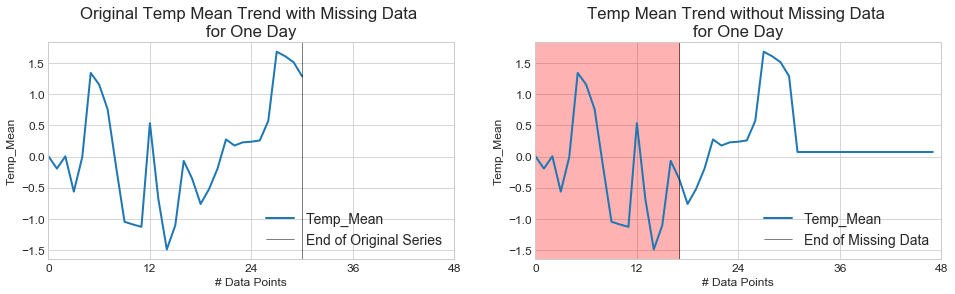

In [191]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

plt.rcParams.update({'font.size': 14,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'lines.linewidth': 2,
                    'axes.labelsize': 12,
                    'figure.figsize': (16, 4)})

ebov_before = pd.read_csv('EBOV-Cyno-Aero-1.csv-Table 1.csv')
ebov_before = ebov_before[(
    ebov_before['SubjectName'] == 'e1001') & (
    ebov_before['Day'] == 0) & (
    ebov_before['Y'] == 0)]
ebov_before_variable = ebov_before['Temp_Mean']
plt.subplot(1, 2, 1)
ebov_before_variable.plot()
plt.xlim([0, 48])
plt.xticks([0, 12, 24, 36, 48])
plt.xlabel(
    '# Data Points')
plt.ylabel(
    'Temp_Mean')
plt.title(
    'Original Temp Mean Trend with Missing Data \nfor One Day')
plt.axvline(
    ebov_before_variable.index[-1], color='black', lw=0.5, label='End of Original Series')
plt.legend()

plt.subplot(1, 2, 2)

ebov_after = pd.read_csv(
    'transformed_csvs/EBOV-Cyno-Aero-1_transformed.csv').drop(columns='Unnamed: 0')
ebov_after = ebov_after[(
    ebov_after['SubjectName'] == 'e1001') & (
    ebov_after['Day'] == -7) & (
    ebov_after['Y'] == 0)]
ebov_after_variable = ebov_after['Temp_Mean']
ebov_after_variable.plot()
plt.xlim([0, 47])
plt.xticks([0, 12, 24, 36, 48])
plt.xlabel(
    '# Data Points')
plt.ylabel(
    'Temp_Mean')
plt.title(
    'Temp Mean Trend without Missing Data \nfor One Day')
plt.axvline(
    47 - ebov_before_variable.index[-1], color='black', lw=0.5, label='End of Missing Data')
plt.axvspan(
    0, 47 - ebov_before_variable.index[-1], color='red', alpha=0.3)
plt.legend()

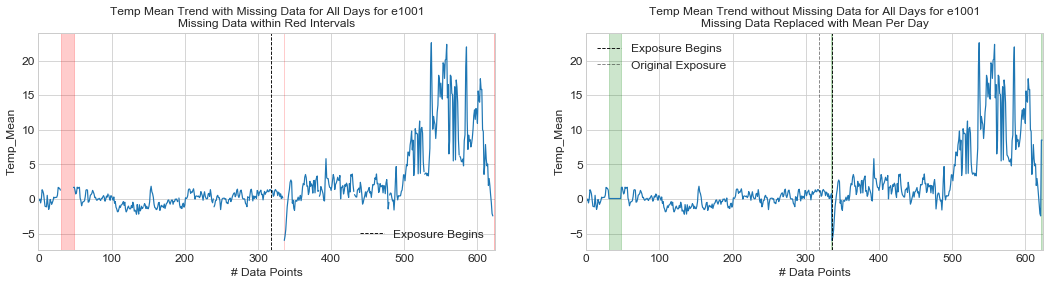

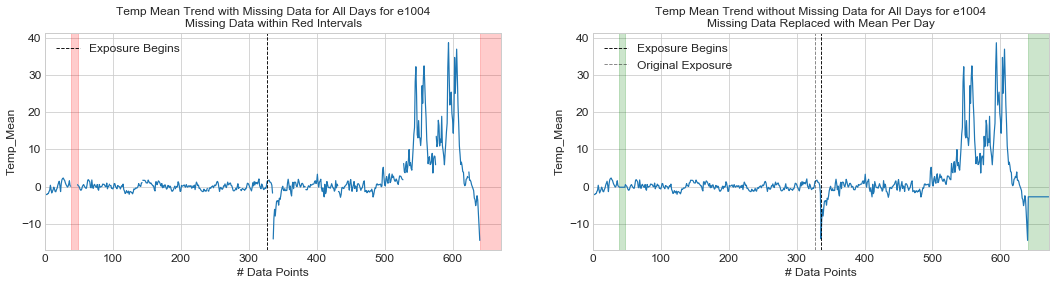

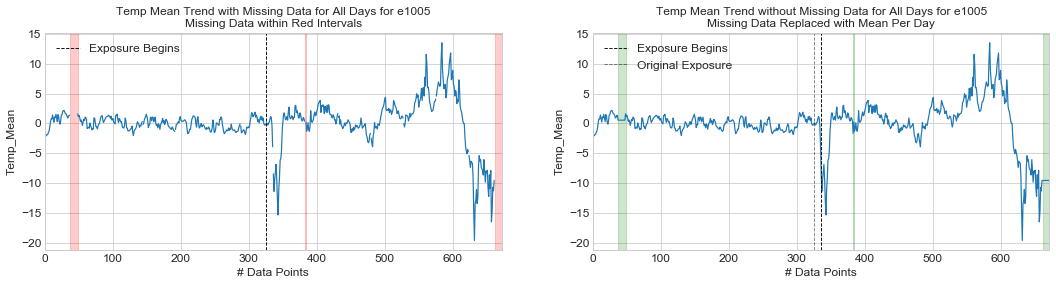

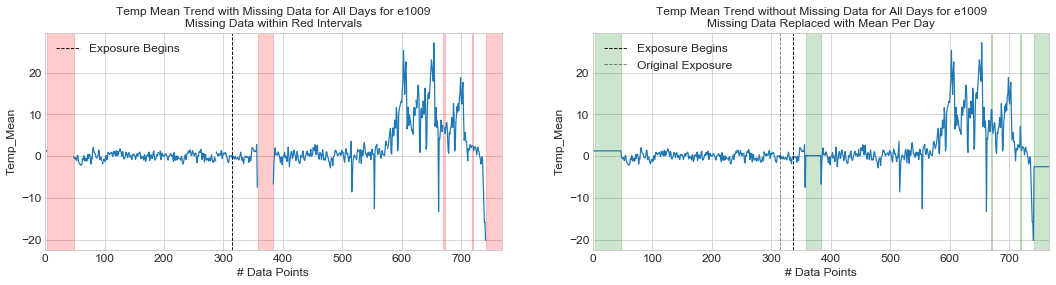

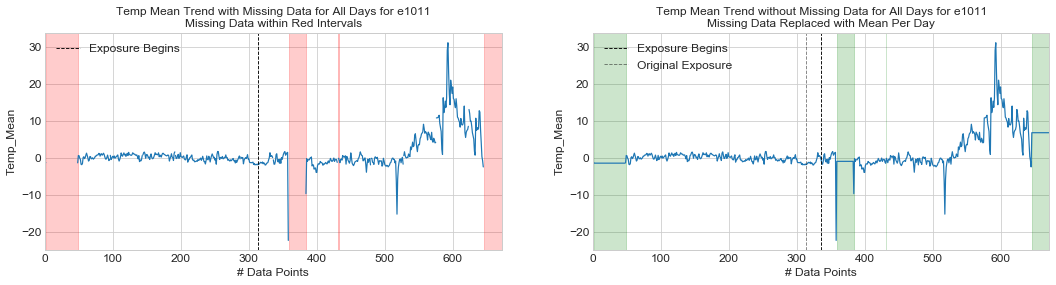

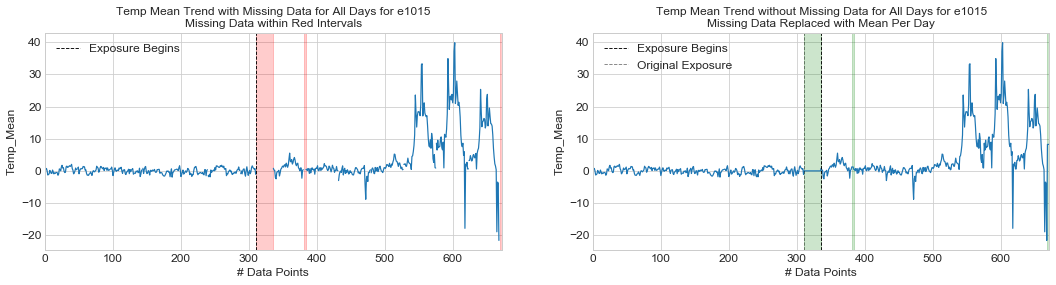

In [251]:
def plot_fill_missing(subj):
    ebov_before = recenter_df('EBOV-Cyno-Aero-1.csv-Table 1.csv', subj)[['Day', 'Temp_Mean', 'Y']]
    ebov_after = pd.read_csv('transformed_csvs/EBOV-Cyno-Aero-1_transformed.csv')
        
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    days = np.unique(ebov_before['Day'])
    ax[0].set_xlim(
        [0, len(days) * 48])
    for i in range(len(days)):
        day_df = ebov_before[ebov_before['Day'] == days[i]]
        day_df_vals = np.append(
            day_df[
                'Temp_Mean'].values, np.repeat(np.nan, (48 - len(day_df))))
        ax[0].plot(range(
            48 * i, 48 * (i + 1)), 
                   day_df_vals, 
                   color='tab:blue',
                   lw=1.2)
        if len(day_df) % 48 != 0:
            ax[0].axvspan(
                len(day_df) + 48 * i, 48 * (i + 1), 
                alpha=0.2, color='r')
            ax[1].axvspan(
                len(day_df) + 48 * i, 48 * (i + 1), 
                alpha=0.2, color='g')
    ax[0].axvline(
        ebov_before[
            ebov_before['Y'] == 1].index[0], 
        color='black', 
        linestyle='--', 
        lw=0.9,
        label='Exposure Begins')
    ax[0].set_title(
        'Temp Mean Trend with Missing Data for All Days for ' + subj + '\nMissing Data within Red Intervals',
        fontsize=12)
    ax[0].set_xlabel(
        '# Data Points')
    ax[0].set_ylabel(
        'Temp_Mean')
    ax[0].legend(fontsize=12)
    ax[1].set_xlim([0, len(days) * 48])
    subj_after = ebov_after[ebov_after['SubjectName'] == subj].reset_index()
    ax[1].plot(subj_after['Temp_Mean'], lw=1.2)
    ax[1].axvline(ebov_after[
        ebov_after['Y'] == 1].index[0], 
                  color='black', 
                  linestyle='--', 
                  lw=0.9,
                  label='Exposure Begins')
    ax[1].axvline(ebov_before[
        ebov_before['Y'] == 1].index[0], 
                  color='black', 
                  alpha=0.5, 
                  linestyle='--', 
                  lw=0.9,
                  label='Original Exposure')
    ax[1].set_title(
        'Temp Mean Trend without Missing Data for All Days for ' + subj + '\nMissing Data Replaced with Mean Per Day',
        fontsize=12)
    ax[1].set_xlabel(
        '# Data Points')
    ax[1].set_ylabel(
        'Temp_Mean')
    ax[1].legend(fontsize=12)
    
for subj in np.unique(pd.read_csv('EBOV-Cyno-Aero-1.csv-Table 1.csv')['SubjectName']):
    plot_fill_missing(subj)